
# Training and evaluation pipeline

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from IPython.display import Image
import requests

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
!pip install gdown


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


## Load and normalize the Caltech training and test datasets



The output of torchvision datasets are PILImage images of range [0, 255]. We first convert them to Tensors in the range [0,1] and then normalize by subtracting the mean and dividing by the standard deviation.
<!-- We transform them to Tensors of normalized range [-1, 1]. -->

In [3]:
from torchvision.datasets import Caltech101
from torch.utils.data import DataLoader
from PIL import Image

# Define the transformation pipeline (without forcing grayscale)
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize images to 128x128
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize
])

# Custom dataset wrapper to handle grayscale images correctly
class Caltech101DatasetWrapper(Caltech101):
    def __getitem__(self, index):
        img, label = super().__getitem__(index)  # Get image and label
        if img.mode != "RGB":  # Convert only grayscale images to RGB
            img = img.convert("RGB")
        img = transform(img)  # Apply transformations
        return img, label

# Load the train dataset
trainset = Caltech101DatasetWrapper(root='./data', download=True)
trainloader = DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

# Load the test dataset
testset = Caltech101DatasetWrapper(root='./data', download=True)
testloader = DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

# Get class labels
classes = trainset.categories

print(f"Loaded {len(trainset)} training images across {len(classes)} categories.")



Files already downloaded and verified


Files already downloaded and verified
Loaded 8677 training images across 101 categories.


Let us show some of the training images, for fun.



In [4]:
def inv_normalize(tensor, mean, std):
    mean = torch.tensor(mean).view(3, 1, 1)
    std = torch.tensor(std).view(3, 1, 1)
    return tensor * std + mean


def make_viewable(img_tensor):
    img_tensor = inv_normalize(img_tensor, mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    img_tensor = torch.clamp(img_tensor, 0, 1)
    return transforms.ToPILImage()(img_tensor)


def imshow(imgs, labels, classes):
    fig, ax = plt.subplots(1, len(imgs), figsize=(12, 6))
    if len(imgs) == 1:
        ax = [ax]  # Ensure ax is iterable for a single image

    for i in range(len(imgs)):
        img = make_viewable(imgs[i])
        ax[i].imshow(img)
        ax[i].set_title(classes[labels[i]])
        ax[i].axis('off')

    plt.show()

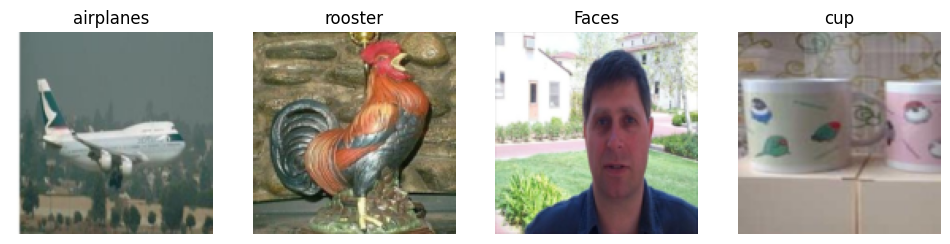

Labels: ['airplanes', 'rooster', 'Faces', 'cup']


In [5]:
import matplotlib.pyplot as plt


# Retrieve a batch of images from the trainloader
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Show the images using the updated function
imshow(images, labels, classes)

# Print labels for better readability
print("Labels:", [classes[label] for label in labels])

In [7]:
class MLP(nn.Module):
    def __init__(self, input_size=128*128*3, num_classes=101):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten input
        x = F.relu(self.fc1(x))
        x = ## Apply fc2 on x followed by relu
        x = self.fc3(x)  # Output layer
        return x

SyntaxError: invalid syntax (432310725.py, line 11)

# Train the network

This is when things start to get interesting.
We simply have to loop over our data iterator, and feed the inputs to the
network and optimize.



In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

def train_net(net, trainloader, epochs=5, lr=0.001, momentum=0.9):
    """
    Trains the given network using a specified DataLoader and hyperparameters.

    Args:
        net (nn.Module): The neural network to train.
        trainloader (DataLoader): DataLoader for the training data.
        epochs (int, optional): Number of epochs (full passes over the dataset). Default is 5.
        lr (float, optional): Learning rate for the optimizer. Default is 0.001.
        momentum (float, optional): Momentum factor for SGD. Default is 0.9.
        device (str, optional): 'cuda' or 'cpu'. If None, automatically checks availability. Default is None.
    """
    print(f"Using device: {device}")

    # Move model to the chosen device
    net.to(device)

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum)

    # Training loop
    for epoch in range(epochs):
        running_loss = 0.0

        for i, data in enumerate(trainloader, 0):
            inputs, labels = data

            # Move inputs and labels to GPU/CPU

            # Zero the parameter gradients

            # Forward pass

            # Backward pass + optimize

            # Track running loss for printing
            running_loss += loss.item()
            if i % 2000 == 1999:  # Print every 2000 mini-batches
                print(f"[epoch: {epoch+1}, iteration: {i+1:5d}] loss: {running_loss/2000:.3f}")
                running_loss = 0.0

    print("Finished Training")

In [ ]:
def eval_net(net, testloader):
    """
    Evaluates the given trained network using a test DataLoader.

    Args:
        net (nn.Module): The trained neural network.
        testloader (DataLoader): DataLoader for the test data.
    """
    correct = 0
    total = 0

    # No gradient calculations needed for evaluation
    with torch.no_grad():
        for data in testloader:
            images, labels = data

            # Move images and labels to the correct device
            images, labels = images.to(device), labels.to(device)

            # Forward pass: Get predictions
            outputs = net(images)
            _, predicted = torch.max(outputs, 1)

            # Update total and correct count
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Print accuracy
    print(f'Accuracy of the network on the test images: {100 * correct / total:.2f} %')

In [ ]:
net = MLP(num_classes=101)
print(net)
train_net(net, trainloader, epochs=15, lr=0.001, momentum=0.9)
eval_net(net, testloader)

MLP(
  (fc1): Linear(in_features=49152, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=101, bias=True)
)
Using device: cuda
[epoch: 1, iteration:  2000] loss: 3.100
[epoch: 2, iteration:  2000] loss: 2.394
[epoch: 3, iteration:  2000] loss: 2.007
[epoch: 4, iteration:  2000] loss: 1.737
[epoch: 5, iteration:  2000] loss: 1.493
[epoch: 6, iteration:  2000] loss: 1.280
[epoch: 7, iteration:  2000] loss: 1.157
[epoch: 8, iteration:  2000] loss: 0.980
[epoch: 9, iteration:  2000] loss: 0.941
[epoch: 10, iteration:  2000] loss: 0.871
[epoch: 11, iteration:  2000] loss: 0.853
[epoch: 12, iteration:  2000] loss: 0.869
[epoch: 13, iteration:  2000] loss: 0.889
[epoch: 14, iteration:  2000] loss: 0.882
[epoch: 15, iteration:  2000] loss: 1.009
Finished Training
Accuracy of the network on the test images: 80.59 %


# Define a Convolutional Neural Network

We can place multiple layers of convolutions on top of each otner (also called 'stacking layers') to create a 'deep' convolutional neural network. We need the neural network to take an input of 3-channel images so our ``in_channels`` for the first convolutional layer must be 3.



In [ ]:
class CNN(nn.Module):
    def __init__(self, num_classes=101):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(??, ??, kernel_size=3, padding=1).   ### what should be the input and output channels?
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(128 * 16 * 16, 512)  # Adjusted for 128x128 image size
        self.fc2 = nn.Linear(512, ??)
        self.fc3 = nn.Linear(256, num_classes)  # Output 101 classes for Caltech-101

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = ### Apply the last layer here
        x = x.view(x.size(0), -1)  # Flatten for fully connected layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
net = CNN(num_classes=101)
print(net)
train_net(net, trainloader, epochs=15, lr=0.001, momentum=0.9)
eval_net(net, testloader)

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=32768, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=101, bias=True)
)
Using device: cuda
[epoch: 1, iteration:  2000] loss: 3.657
[epoch: 2, iteration:  2000] loss: 2.758
[epoch: 3, iteration:  2000] loss: 2.220
[epoch: 4, iteration:  2000] loss: 1.702
[epoch: 5, iteration:  2000] loss: 1.216
[epoch: 6, iteration:  2000] loss: 0.748
[epoch: 7, iteration:  2000] loss: 0.434
[epoch: 8, iteration:  2000] loss: 0.260
[epoch: 9, iteration:  2000] loss: 0.141
[epoch: 10, iteration:  2000] loss: 0.102
[epoch: 11, iteration:  2000] loss: 0.089
[epoch: 12, itera

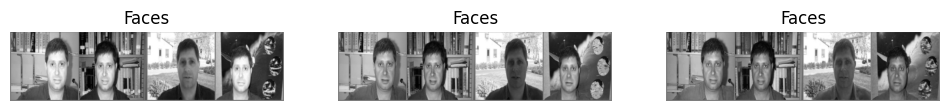

Predicted:  Faces Faces Faces Faces


In [ ]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# Move images and labels to GPU (if available)
images, labels = images.to(device), labels.to(device)

# Forward pass: Get predictions from the model
outputs = net(images)
_, predicted = torch.max(outputs, 1)  # Get the class index with highest probability


imshow(images.cpu(), predicted.cpu(), classes)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j].item()] for j in range(len(predicted))))